# Expedia Hotel Ranking 

The purpose of this notebook is to construct models to rank properties based on customers' preferences.

## Table of Contents

1. [Import Packages and Load the Data](#Import-Packages-and-Load-the-Data)  
2. [Data Exploration](#Data-Exploration) 
    1. [Goals](#Goals)  
    2. [Data Size and Missing Data](#Data-Size-and-Missing-Data) 
    3. [Summary Statistics](#Summary-statistics) 
    4. [Investigate property room capacity](#Investigate-negative-property-room-capcity)  
    5. [Check property price column](#Use-correlations-to-check-if-the-property-price-is-per-night-per-room) 
    6. [Check frequency of search query](#Check-frequency-of-number-of-search-queries-in-the-dataset)   
3. [Model Selection and Process the Data](#Model-Selection-and-Process-the-Data) 
    1. [Collaborative Filtering Model](#Check-if-collaborative-filtering-model-is-a-good-fit-for-the-problem)  
    2. [Latent Factor Model](#Latent-Factor-Model)   
        1. [User-item interaction matrix](#Create-user-item-matrix)
        2. [Feature Engineering](#Feature-engineering)
        3. [Define user and property parameters](#Define-user-and-property-parameters)
        4. [Implicit Feedback with Alternating Least Square Algorithm](#Implicit-feedback-recommendation-with-Alternating-Least-Square-algorithm)
        5. [Implicit Feedback with logistic probabilistic model](#Implicit-feedback-recommendation-using-logistic-latent-Factor-model) 
4. [Latent Factor, Implicit Feedback, Logistic Probabilistic Model](#Implicit-feedback-recommendation-using-logistic-latent-Factor-model)
    1. [Model Training](#Initialize-the-model,-train-the-model,-and-get-user-and-item-latent-vectors)
    2. [Model Prediction](#Model-Prediction)

# Import Packages and Load the Data

In [218]:
import pandas as pd
import numpy as np
import os
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import matplotlib.pyplot as plt
from numpy.linalg import inv
from IPython.display import display
from tqdm import tqdm, notebook
from joblib import Parallel, delayed 
import time
import pickle
from sklearn.metrics.pairwise import cosine_similarity

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
%matplotlib inline

In [17]:
ROOT_PATH = os.getcwd()
DATA_PATH = os.path.join(ROOT_PATH, "data")
OUTPUT_PATH = os.path.join(ROOT_PATH, "output")
train_data_file = os.path.join(DATA_PATH, "train.csv")
test_data_file = os.path.join(DATA_PATH, "test.csv")

train = pd.read_csv(train_data_file)
test = pd.read_csv(test_data_file)

# Data Exploration
### Goals
- What is the shape of the data?  <br>
- Is there any missing data?  <br>
- Is there any abnormal data that needs to be fixed or removed? <br>

### Data Size and Missing Data

In [259]:
# check number of datapoints
print("shape of the training set: " + str(train.shape))
print("shape of the test set: " + str(test.shape))

print("unique number of search ids: " + str(train.srch_id.nunique()))
print("unique number of visitors: " + str(train.srch_visitor_id.nunique()))
print("unique number of properties: " + str(train.prop_key.nunique()))

shape of the training set: (841115, 47)
shape of the test set: (351544, 46)
unique number of search ids: 24013
unique number of visitors: 23101
unique number of properties: 6330


### Relationship between train and test set

In [260]:
# overlap of users between train and test set
shared_users = len(set(train.srch_visitor_id.unique()).intersection(set(test.srch_visitor_id.unique())))
print("overlapping visitors: " + str(shared_users))
train_users_num = train.srch_visitor_id.nunique()
test_users_num = test.srch_visitor_id.nunique()
print("percentage of shared users respect to training set: " + str(round(shared_users*100/train_users_num,2)) + "%")
print("percentage of shared users respect to testing set: " + str(round(shared_users*100/test_users_num,2)) + "%")

overlapping visitors: 614
percentage of shared users respect to training set: 2.66%
percentage of shared users respect to testing set: 6.24%


In [6]:
train.head()

,srch_id,prop_key,srch_date_time,srch_visitor_id,srch_visitor_visit_nbr,srch_visitor_loc_country,srch_visitor_loc_region,srch_visitor_loc_city,srch_visitor_wr_member,srch_posa_continent,srch_posa_country,srch_hcom_destination_id,srch_dest_longitude,srch_dest_latitude,srch_ci,srch_co,srch_ci_day,srch_co_day,srch_los,srch_bw,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_mobile_bool,srch_mobile_app,srch_device,srch_currency,prop_travelad_bool,prop_dotd_bool,prop_price_without_discount_local,prop_price_without_discount_usd,prop_price_with_discount_local,prop_price_with_discount_usd,prop_imp_drr,prop_brand_bool,prop_starrating,prop_super_region,prop_continent,prop_country,prop_market_id,prop_submarket_id,prop_room_capacity,prop_review_score,prop_review_count,prop_hostel_bool,srch_local_date
0,-1087756044,3075608,2014-09-03 21:32:28,7c79d759-5939-48b5-b2b3-cca67413dc39,3,UNITED STATES OF AMERICA,OH,CLEVELAND,NaN,NaN,US,1506246,-73.986473,40.75668,2014-09-05,2014-09-06,6,7,1,2,2,0,1,1,0,TABWEB,USD,0,0,535.0,535.0,199.0,199.0,0,0,4.0,AMER,NORTHAMERICA,UNITED STATES OF AMERICA,95656,96809,90,4.3,344.0,0,2014-09-03
1,-1087756044,242706,2014-09-03 21:32:28,7c79d759-5939-48b5-b2b3-cca67413dc39,3,UNITED STATES OF AMERICA,OH,CLEVELAND,NaN,NaN,US,1506246,-73.986473,40.75668,2014-09-05,2014-09-06,6,7,1,2,2,0,1,1,0,TABWEB,USD,0,0,549.0,549.0,219.0,219.0,0,1,4.0,AMER,NORTHAMERICA,UNITED STATES OF AMERICA,95656,96810,596,4.0,2494.0,0,2014-09-03
2,-1087756044,247231,2014-09-03 21:32:28,7c79d759-5939-48b5-b2b3-cca67413dc39,3,UNITED STATES OF AMERICA,OH,CLEVELAND,NaN,NaN,US,1506246,-73.986473,40.75668,2014-09-05,2014-09-06,6,7,1,2,2,0,1,1,0,TABWEB,USD,0,0,635.0,635.0,245.0,245.0,0,1,4.0,AMER,NORTHAMERICA,UNITED STATES OF AMERICA,95656,96812,426,4.4,1129.0,0,2014-09-03
3,-1087756044,258704,2014-09-03 21:32:28,7c79d759-5939-48b5-b2b3-cca67413dc39,3,UNITED STATES OF AMERICA,OH,CLEVELAND,NaN,NaN,US,1506246,-73.986473,40.75668,2014-09-05,2014-09-06,6,7,1,2,2,0,1,1,0,TABWEB,USD,0,0,402.0,402.0,209.0,209.0,0,0,4.0,AMER,NORTHAMERICA,UNITED STATES OF AMERICA,95656,96812,-9998,3.6,4629.0,0,2014-09-03
4,-1087756044,3407116,2014-09-03 21:32:28,7c79d759-5939-48b5-b2b3-cca67413dc39,3,UNITED STATES OF AMERICA,OH,CLEVELAND,NaN,NaN,US,1506246,-73.986473,40.75668,2014-09-05,2014-09-06,6,7,1,2,2,0,1,1,0,TABWEB,USD,0,0,609.0,609.0,269.0,269.0,0,1,4.0,AMER,NORTHAMERICA,UNITED STATES OF AMERICA,95656,96812,597,4.7,953.0,0,2014-09-03
5,-1087756044,582436,2014-09-03 21:32:28,7c79d759-5939-48b5-b2b3-cca67413dc39,3,UNITED STATES OF AMERICA,OH,CLEVELAND,NaN,NaN,US,1506246,-73.986473,40.75668,2014-09-05,2014-09-06,6,7,1,2,2,0,1,1,0,TABWEB,USD,0,0,840.0,840.0,175.0,175.0,0,1,3.5,AMER,NORTHAMERICA,UNITED STATES OF AMERICA,95656,96812,250,4.1,665.0,0,2014-09-03
6,-1087756044,3405235,2014-09-03 21:32:28,7c79d759-5939-48b5-b2b3-cca67413dc39,3,UNITED STATES OF AMERICA,OH,CLEVELAND,NaN,NaN,US,1506246,-73.986473,40.75668,2014-09-05,2014-09-06,6,7,1,2,2,0,1,1,0,TABWEB,USD,0,0,450.0,450.0,189.0,189.0,0,1,3.5,AMER,NORTHAMERICA,UNITED STATES OF AMERICA,95656,96809,92,4.1,220.0,0,2014-09-03
7,-1087756044,255393,2014-09-03 21:32:28,7c79d759-5939-48b5-b2b3-cca67413dc39,3,UNITED STATES OF AMERICA,OH,CLEVELAND,NaN,NaN,US,1506246,-73.986473,40.75668,2014-09-05,2014-09-06,6,7,1,2,2,0,1,1,0,TABWEB,USD,0,0,529.0,529.0,279.0,279.0,0,1,4.0,AMER,NORTHAMERICA,UNITED STATES OF AMERICA,95656,96812,1980,4.0,4779.0,0,2014-09-03
8,-1087756044,1108480,2014-09-03 21:32:28,7c79d759-5939-48b5-b2b3-cca67413dc39,3,UNITED STATES OF AMERICA,OH,CLEVELAND,NaN,NaN,US,1506246,-73.986473,40.75668,2014-09-05,2014-09-06,6,7,1,2,2,0,1,1,0,TABWEB,USD,0,0,598.0,598.0,279.0,279.0,0,1,4.5,AMER,NORTHAMERICA,UNITED STATES OF AMERICA,95656,96812,607,4.5,1720.0,0,2014-09-03
9,-1087756044,259899,2014-09-03 21:32:28,7c79d759-5939-48b5-b2b3-cca67413dc39,3,UNITED STATES OF AMERICA,OH,CLEVELAND,NaN,NaN,US,1506246,-73.986473,40.75668,2014-09-05,2014-09-06,6,7,1,2,2,0,1,1,0,TABWEB,USD,0,0,279.0,279.0,223.0,223.0,1,0,3.0,AMER,NORTH

In [4]:
# check missing data
{column: train[column].isnull().sum() for column in train.columns if train[column].isnull().sum() > 0 }

{'prop_price_with_discount_local': 51,
 'prop_price_with_discount_usd': 51,
 'prop_price_without_discount_local': 51,
 'prop_price_without_discount_usd': 51,
 'prop_review_count': 8,
 'prop_review_score': 8,
 'srch_adults_cnt': 18,
 'srch_children_cnt': 18,
 'srch_currency': 134104,
 'srch_posa_continent': 485248,
 'srch_visitor_loc_region': 123,
 'srch_visitor_wr_member': 444878}

In [5]:
{column: test[column].isnull().sum() for column in test.columns if test[column].isnull().sum() > 0 }

{'prop_price_with_discount_local': 11,
 'prop_price_with_discount_usd': 11,
 'prop_price_without_discount_local': 11,
 'prop_price_without_discount_usd': 11,
 'prop_review_count': 6,
 'prop_review_score': 6,
 'srch_currency': 53400,
 'srch_posa_continent': 202751,
 'srch_visitor_loc_region': 111,
 'srch_visitor_wr_member': 181968}

### Observstions
For columns with missing data: <br>
- srch_visitor_wr_member needs to be removed because more than 20% of the data is missing. <br>
- srch_visitor_loc_region, srch_posa_continent, srch_currency, prop_price_without_discount_local, prop_price_without_discount_usd, prop_price_with_discount_local columns can be safely removed as their information is covered by other columns. <br>
- The missing data in prop_price_with_discount_usd, prop_review_count, prop_review_score, srch_adults_cnt, and srch_children_cnt columns need to be imputed. 


### Summary statistics

In [7]:
# numerical variables
train.describe()

,srch_id,prop_key,srch_visitor_visit_nbr,srch_hcom_destination_id,srch_dest_longitude,srch_dest_latitude,srch_ci_day,srch_co_day,srch_los,srch_bw,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_mobile_bool,srch_mobile_app,prop_travelad_bool,prop_dotd_bool,prop_price_without_discount_local,prop_price_without_discount_usd,prop_price_with_discount_local,prop_price_with_discount_usd,prop_imp_drr,prop_booking_bool,prop_brand_bool,prop_starrating,prop_market_id,prop_submarket_id,prop_room_capacity,prop_review_score,prop_review_count,prop_hostel_bool
count,8.411150e+05,8.411150e+05,841115.000000,8.411150e+05,841115.000000,841115.000000,841115.000000,841115.000000,841115.000000,841115.000000,841097.000000,841097.000000,841115.000000,841115.000000,841115.0,841115.000000,841115.000000,8.410640e+05,8.410640e+05,8.410640e+05,8.410640e+05,841115.000000,841115.000000,841115.000000,841115.000000,841115.000000,841115.000000,841115.000000,841107.000000,841107.000000,841115.000000
mean,1.724233e+07,8.185569e+05,12.325977,1.194309e+06,-45.892803,40.445932,4.272102,3.689650,2.677238,35.349157,2.019900,0.161467,1.113059,0.145173,0.0,0.012221,0.003809,1.204508e+04,4.527640e+02,8.519444e+03,3.044565e+02,0.425998,0.028549,0.664118,3.595627,71586.980101,106494.270656,631.116457,4.024048,2160.753578,0.002888
std,1.231757e+09,1.141255e+06,31.788936,4.237267e+05,77.706051,6.056537,2.003199,2.128168,2.192103,49.506785,1.020626,0.546063,0.447657,0.352275,0.0,0.109870,0.061601,1.679273e+05,6.864688e+03,1.130143e+05,4.205190e+03,0.494494,0.166535,0.472298,0.864574,39165.985756,7384.185494,1573.071335,0.547170,3075.169206,0.053661
min,-2.147275e+09,2.407460e+05,1.000000,5.042610e+05,-115.172875,28.541290,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,8.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,369.000000,60556.000000,-9998.000000,0.000000,0.000000,0.000000
25%,-1.034005e+09,2.559520e+05,1.000000,7.267840e+05,-115.172875,36.114666,3.000000,2.000000,1.000000,4.000000,2.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,1.690000e+02,1.440000e+02,1.160000e+02,9.902000e+01,0.000000,0.000000,0.000000,3.000000,60039.000000,98238.000000,144.000000,3.800000,306.000000,0.000000
50%,3.193952e+07,2.777420e+05,3.000000,1.497539e+06,-73.986473,40.756680,5.000000,4.000000,2.000000,17.000000,2.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,3.390000e+02,2.730000e+02,2.350000e+02,1.890000e+02,0.000000,0.000000,1.000000,4.000000,95602.000000,109153.000000,306.000000,4.100000,937.000000,0.000000
75%,1.081646e+09,4.781330e+05,10.000000,1.504033e+06,-0.127804,41.880779,6.000000,6.000000,3.000000,46.000000,2.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,6.650000e+02,4.490000e+02,4.660000e+02,2.990000e+02,1.000000,0.000000,1.000000,4.000000,95656.000000,110287.000000,770.000000,4.400000,2550.000000,0.000000
max,2.147266e+09,3.949856e+06,1082.000000,1.506246e+06,139.759995,51.507538,7.000000,7.000000,28.000000,473.000000,16.000000,8.000000,8.000000,1.000000,0.0,1.000000,1.000000,3.195489e+07,1.976733e+06,1.762130e+07,1.087117e+06,1.000000,1.000000,1.000000,5.000000,116356.000000,116928.000000,19235.000000,5.000000,32399.000000,1.000000


### Observations
1. prop_room_capacity column -- max number of rooms this property has available -- has negative values.  <br>
2. The srch_mobile_app column is all zeros. <br>
3. The prop_imp_drr is binary. It is not sure what does this binary variable mean. <br>

In [11]:
# categorical variables
train.describe(exclude=[np.number]) 

,srch_date_time,srch_visitor_id,srch_visitor_loc_country,srch_visitor_loc_region,srch_visitor_loc_city,srch_visitor_wr_member,srch_posa_continent,srch_posa_country,srch_ci,srch_co,srch_device,srch_currency,prop_super_region,prop_continent,prop_country,srch_local_date
count,841115,841115,841115,840992,841115,396237,355867,841115,841115,841115,841115,707011,841115,841115,841115,841115
unique,23873,23101,151,599,5092,9,4,67,385,376,3,51,4,4,7,28
top,2014-09-22 23:33:00,0fac9b35-d7b7-4b71-b275-7da40310ea2e,UNITED STATES OF AMERICA,CA,NEW YORK,Not Signed In|Returning Visitor|Not FC Member,EUROPE,US,2014-09-26,2014-09-28,DESKTOP,USD,AMER,NORTHAMERICA,UNITED STATES OF AMERICA,2014-09-03
freq,106,800,463183,115310,21172,186401,207181,463532,23604,28497,718871,412926,554304,554304,554304,39487


### Investigate negative property room capcity

In [8]:
print("rows with negative room capacity in the training set: " + str(sum(train.prop_room_capacity < 0)))
print("rows with negative room capacity in the test set: " + str(sum(test.prop_room_capacity < 0)))

rows with negative room capacity in the training set: 10401
rows with negative room capacity in the test set: 4438


In [9]:
train.groupby('prop_room_capacity')['srch_id', 'prop_key'].nunique().head()
#test.groupby('prop_room_capacity')['srch_id', 'prop_key'].nunique().head()

,srch_id,prop_key
prop_room_capacity,,
-9998,6978,103
0,1151,3
1,177,98
2,62,24
3,139,49


All negative values are -9998. It is likely an indication that the data is not available. In the training set, 103 properties have -9998 room capacities, correpsonding to 10401 rows (1%) and 6978 search Ids.
#### Check if properties with negative capacity have any nonnegative records

In [10]:
# all records with negative capacities
neg_capacity_row = train[train.prop_room_capacity < 0]
neg_capacity_property = set(neg_capacity_row.prop_key)
count_neg_capacity_property = neg_capacity_row.groupby('prop_key')['srch_id'].count()

# all records from properties that have negative capacity 
neg_capacity_property_all_records = train[train.prop_key.isin(neg_capacity_property)]
count_neg_capacity_property_all_records = neg_capacity_property_all_records.groupby('prop_key')['srch_id'].count()

# check if total number of records per property match
print("Properties with negative capacity data do not have other records: ")
print(count_neg_capacity_property.equals(count_neg_capacity_property_all_records))

# check if these properties exist in the test set
print("Do these properties exist in the test set: ")
print(any(test.prop_key.isin(neg_capacity_property)))

Properties with negative capacity data do not have other records: 
True
Do these properties exist in the test set: 
True


### Implications
1. Properties without room capacity info should be given a low rank because we are not sure if they have enough capacities to accomodate customers' needs.
2. Consider removing srch_mobile_app and prop_imp_drr columns.

### Use correlations to check if the property price is per night per room

In [12]:
print("correlations between price and length of stay: " + str(train.srch_los.corr(train.prop_price_with_discount_usd)))
print("correlations between price and room requested: " + str(train.srch_rm_cnt.corr(train.prop_price_with_discount_usd)))

correlations between price and length of stay: -0.00579965687736
correlations between price and room requested: -0.00178066443409


Since the correlations between price and the length of day and between price and room requested are small and negative, it is likely that the price is per night and per room.

### Check frequency of number of search queries in the dataset

(array([   373.,   7785.,    123.,    143.,    215.,    317.,    690.,
           617.,   1237.,  12513.]),
 array([  1. ,   6.3,  11.6,  16.9,  22.2,  27.5,  32.8,  38.1,  43.4,
         48.7,  54. ]),
 <a list of 10 Patch objects>)

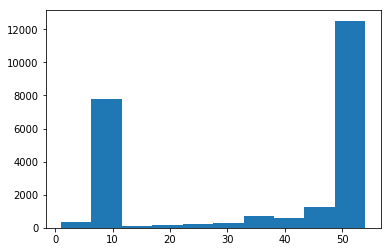

In [13]:
counter = Counter(train.srch_id)
counter.most_common()[:-10-1:-1]
plt.hist(list(counter.values()))

# Model Selection and Process the Data

### Check if collaborative filtering model is a good fit for the problem

The first potential model for this problem is the collaborative filtering model. The model has two types: user-user collaborative filtering and item-item collaborative filtering. The first type requires enough visitors in the system who booked the same property. The second type requies that the visitors booked enough properties. <br>
To see if the model is a good fit of my problem, I checked bookings per user. <br>
An alternative model is the content-based filtering model.

In [249]:
print("statistics of bookings per visitor: ")
print(train.groupby('srch_visitor_id')['prop_booking_bool'].sum().describe())
print("95 percentile: " + str(np.percentile(train.groupby('srch_visitor_id')['prop_booking_bool'].sum(), 95)))

statistics of bookings per visitor: 
count    23101.000000
mean         1.039479
std          0.316091
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         25.000000
Name: prop_booking_bool, dtype: float64
95 percentile: 1.0


In [250]:
print("statistics of bookings per search: ")
print(train.groupby('srch_id')['prop_booking_bool'].sum().describe())
print("95 percentile: " + str(np.percentile(train.groupby('srch_id')['prop_booking_bool'].sum(), 95)))

statistics of bookings per search: 
count    24013.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: prop_booking_bool, dtype: float64
95 percentile: 1.0


### Observations
Most visitors have only one booking. This is not enough for collaborative filtering model to work.  <br>
Content based filtering is not suitable as well. While we can build a user profile, there are 94% new users in the test set and using the global mean as user profiles for unseen users is not effective.

### Latent Factor Model

### Create user-item matrix

In [3]:
# Create a list of properties present in the train and test set
all_properties = list(set(train.prop_key.unique()).union(set(test.prop_key.unique())))

In [4]:
# Create user-property booking matrix
def create_user_property_matrix(df, properties_set):
    properties = np.sort(properties_set)
    users = np.sort(df.srch_visitor_id.unique())

    # map unique properties and users to index values
    properties_with_index = pd.DataFrame({'index_p':range(0,len(properties)), 'properties':properties})
    users_with_index = pd.DataFrame({'index_u':range(0,len(users)), 'users':users})

    # join dataframe with property and user index
    df_add_properties_index = df.join(properties_with_index.set_index('properties'), on='prop_key')
    df_add_users_properties_index = df_add_properties_index.join(users_with_index.set_index('users'), on='srch_visitor_id')
    
    # get the number of bookings per property-user pair
    num_bookings_df = df_add_users_properties_index.groupby(['index_p', 'index_u'])['prop_booking_bool'].sum().reset_index(name='num_booking')
    num_bookings_nonzero_df = num_bookings_df[num_bookings_df.num_booking != 0]
    
    booking_matrix = np.zeros((len(users), len(properties)))
    
    property_index = np.array(num_bookings_nonzero_df.index_p)
    user_index = np.array(num_bookings_nonzero_df.index_u)
    num_bookings = np.array(num_bookings_nonzero_df.num_booking)
    booking_matrix[user_index, property_index] = num_bookings
    
    return properties_with_index, users_with_index, booking_matrix

In [5]:
properties_idx_mapping, users_idx_mapping, user_property_booking_matrix = create_user_property_matrix(train, all_properties)

In [6]:
# Save index mapping and user_item_matrix 
properties_idx_mapping_path = os.path.join('output', 'orig_train_properties_idx_mapping.pickle')
users_idx_mapping_path = os.path.join('output', 'orig_train_users_idx_mapping.pickle')
user_property_booking_matrix_path = os.path.join('output', 'orig_train_user_property_matrix.pickle')

with open(properties_idx_mapping_path, 'wb') as output_prop:
    pickle.dump(properties_idx_mapping, output_prop)

with open(users_idx_mapping_path, 'wb') as output_user:
    pickle.dump(users_idx_mapping, output_user)
    
with open(user_property_booking_matrix_path, 'wb') as output_matrix:
    pickle.dump(user_property_booking_matrix, output_matrix)

In [ ]:
with open(properties_idx_mapping_path, 'rb') as input_prop:
    properties_idx_mapping = pickle.load(input_prop)

with open(users_idx_mapping_path, 'rb') as input_user:
    users_idx_mapping = pickle.load(input_user)
    
with open(user_property_booking_matrix_path, 'rb') as input_matrix:
    user_property_booking_matrix = pickle.load(input_matrix)

### Feature engineering

In [7]:
def create_imputation_map(df):
    na_columns = ['prop_price_with_discount_usd', 'prop_review_count', 
              'prop_review_score', 'srch_adults_cnt', 'srch_children_cnt']
    impute_dict = {}
    
    for column in na_columns:
        column_mean = np.nanmean(df[column], axis=0)
        impute_dict[column] = column_mean

    return impute_dict

In [8]:
def preprocessing(df, impute_dict):
    # remove columns that do not have enough datapoints or do not provide useful info
    new_df = df.drop(['srch_visitor_wr_member', 
                 'srch_visitor_loc_region',
                 'srch_posa_continent',
                 'srch_currency',
                 'srch_mobile_app',
                 'prop_imp_drr'], axis=1)
    
    # create a column of month for a particular search
    new_df['srch_local_month'] = pd.to_datetime(new_df['srch_local_date']).dt.month
    new_df['srch_checkin_month'] = pd.to_datetime(new_df['srch_ci']).dt.month
    new_df['srch_checkin_day'] = pd.to_datetime(new_df['srch_ci']).dt.day
    
    # impute columns with missing values     
    new_df.fillna(value = impute_dict, inplace=True)
    
    '''
    #new_df.srch_visitor_loc_city_str = new_df.srch_visitor_loc_city.astype('str')
    #new_test_df.srch_visitor_loc_city_str = new_test_df.srch_visitor_loc_city.astype('str')
    
    # encode search city
    label_encoder = LabelEncoder() 
    label_encoder.fit(new_df.srch_visitor_loc_city)
    label_encoder.categories_
    new_df['srch_visitor_loc_city_encoded'] = label_encoder.transform(new_df.srch_visitor_loc_city) 

    #enc = OneHotEncoder()
    #enc.fit(new_df.srch_visitor_loc_city_str)
    #enc.categories_
    #enc_city_train = enc.transform(new_df[['srch_visitor_loc_city_str']]).toarray()
    #enc_city_test = enc.transform(new_test_df[['srch_visitor_loc_city_str']]).toarray()
    
    #new_df_encoded = np.concatenate((new_df, enc_city_train), axis = 1)
    #new_test_df_encoded = np.concatenate((new_test_df, enc_city_test), axis = 1)
    '''
    
    return new_df

In [9]:
impute_dict = create_imputation_map(train)
train_processed = preprocessing(train, impute_dict)
test_processed = preprocessing(test, impute_dict)

In [ ]:
# Save processed dataframe 
train_processed_path = os.path.join(OUTPUT_PATH, "train_processed.pickle")
test_processed_path = os.path.join(OUTPUT_PATH, "test_processed.pickle")

with open(train_processed_path, 'wb') as trainOutput:
    pickle.dump(train_processed, trainOutput)

with open(test_processed_path, 'wb') as testOutput:
    pickle.dump(test_processed, testOutput)

In [ ]:
with open(train_processed_path, 'rb') as trainInput:
    train_processed = pickle.load(trainInput)

with open(test_processed_path, 'rb') as testInput:
    test_processed = pickle.load(testInput)

### Define user and property parameters

In [10]:
# Create user features df
user_parameters = ['srch_visitor_visit_nbr',
                   'srch_dest_longitude',
                   'srch_dest_latitude',
                   'srch_checkin_month',
                   'srch_checkin_day',
                   'srch_ci_day', 
                   'srch_los', 
                   'srch_bw',
                   'srch_adults_cnt', 
                   'srch_children_cnt', 
                   'srch_rm_cnt', 
                   'srch_mobile_bool',
                   'srch_local_month'
                   ]

In [11]:
property_features = ['prop_key',
                     'prop_travelad_bool',
                     'prop_dotd_bool',
                     'prop_price_with_discount_usd',
                     'prop_brand_bool',
                     'prop_starrating',
                     'prop_submarket_id',
                     'prop_room_capacity',
                     'prop_review_score',
                     'prop_review_count',
                     'prop_hostel_bool']

### Implicit feedback recommendation with Alternating Least Square algorithm

Params:
- k: The 'k' latent factors to be considered. Default: 20.
- lam_1: Regularization param for P (user factors). Default: 0.1
- lam_2: Regularization param for Q (item factors). Default: 0.1
- max_iter: The number of iterations over the whole dataset. Default: 100.

Parameter values:
- k = 20
- lam_1 = 0.1
- lam_2 = 0.1
- max_iter = 100

In [26]:
def ALS(df, user_property_matrix, u_idx_mapping, p_idx_mapping, k=5, lam_1=0.1, lam_2=0.1, max_iter=10):
    
    #mu = np.sum(df.prop_booking_bool) / np.sum(df.prop_booking_bool != 0)
    #Bx = pd.DataFrame({'user_index':u_idx_mapping.index_u, 
    #                   'avg_rating_user':np.true_divide(np.sum(user_property_matrix, axis=1), np.sum(user_property_matrix != 0, axis=1))-mu})
    #Bi = pd.DataFrame({'property_index':p_idx_mapping.index_p, 
    #                   'avg_rating_prop':np.true_divide(np.sum(user_property_matrix, axis=0), np.sum(user_property_matrix != 0, axis=0))-mu})
    # some properties do not have any bookings, so 0/0 creates NAN
    #Bi.fillna(0)
    
    max_num_booking = np.max(user_property_matrix)
    num_properties = p_idx_mapping.shape[0]
    num_users = u_idx_mapping.shape[0]
    Q = np.random.uniform(0, np.sqrt(max_num_booking / k), size=(num_properties, k))
    P = np.random.uniform(0, np.sqrt(max_num_booking / k), size=(num_users, k))

    # sparsity ratio and other parameters
    alpha = np.sum(user_property_matrix > 0) / np.sum(user_property_matrix == 0)
    #k, lam_1, lam_2, lam_3, lam_4, max_iter = params
    
    cost = np.zeros(max_iter)
    preference_matrix = (user_property_matrix > 0) * 1
    confidence_matrix = 1 + alpha * user_property_matrix
    
    def update_item_matrix(i):
        p_i = preference_matrix[:,i]
        C_i = np.diag(confidence_matrix[:,i])
        pT_c_p = temp_P + (P.T).dot(C_i - np.identity(num_users)).dot(P)
        Q[i,:] = inv(pT_c_p + lam_1 * np.identity(k)).dot(P.T).dot(C_i).dot(p_i)
        
    def update_user_matrix(u):
        p_u = preference_matrix[u,:]
        C_u = np.diag(confidence_matrix[u,:])
        qT_c_q = temp_Q + (Q.T).dot(C_u - np.identity(num_properties)).dot(Q)
        P[u,:] = inv(qT_c_q + lam_2 * np.identity(k)).dot(Q.T).dot(C_u).dot(p_u)
    
    # X = User = P
    # Y = Items = Q
    # n = num_properties
    # m = num_users

    for iter in tqdm(range(max_iter)):
        temp_P = np.dot(P.T,P)
        Parallel(n_jobs=-1)(delayed(update_item_matrix)(i) for i in tqdm(range(num_properties)))
            
        temp_Q = np.dot(Q.T,Q)
        Parallel(n_jobs=-1)(delayed(update_user_matrix)(u) for u in tqdm(range(num_users)))

        cost[iter] = np.sum(confidence_matrix * np.square(preference_matrix - np.dot(P, Q.T))) + lam_1 * np.sum(np.square(X)) + lam_2 * np.sum(np.square(Y))
        
        print("cost after " + str(iter) + " iterations " + str(cost[iter]))
        
    
    return P, Q, cost

In [27]:
#user_matrix, property_matrix, cost = ALS(train, user_property_booking_matrix, users_idx_mapping, properties_idx_mapping)

  2%|▏         | 160/6661 [17:13<11:17:24,  6.25s/it]

KeyboardInterrupt: 

### Observations
ALS algorithm takes too much time to execute. One loop for each property would take 7 hours, so it is not practical due to limited time.

### Implicit feedback recommendation using logistic latent Factor model 

In [12]:
class LogisticMF():

    def __init__(self, counts, num_factors, iterations, reg_param=0.6, gamma=1.0):
        self.counts = counts
        self.num_users = counts.shape[0]
        self.num_items = counts.shape[1]
        self.num_factors = num_factors
        self.iterations = iterations
        self.reg_param = reg_param
        self.gamma = gamma

    def train_model(self):

        self.ones = np.ones((self.num_users, self.num_items))
        self.user_vectors = np.random.normal(size=(self.num_users, self.num_factors))
        self.item_vectors = np.random.normal(size=(self.num_items, self.num_factors))
        self.user_biases = np.random.normal(size=(self.num_users, 1))
        self.item_biases = np.random.normal(size=(self.num_items, 1))

        user_vec_deriv_sum = np.zeros((self.num_users, self.num_factors))
        item_vec_deriv_sum = np.zeros((self.num_items, self.num_factors))
        user_bias_deriv_sum = np.zeros((self.num_users, 1))
        item_bias_deriv_sum = np.zeros((self.num_items, 1))
        
        for i in range(self.iterations):
            t0 = time.time()
            # Fix items and solve for users
            # take step towards gradient of deriv of log likelihood
            # we take a step in positive direction because we are maximizing LL
            user_vec_deriv, user_bias_deriv = self.deriv(True)
            user_vec_deriv_sum += np.square(user_vec_deriv)
            user_bias_deriv_sum += np.square(user_bias_deriv)
            vec_step_size = self.gamma / np.sqrt(user_vec_deriv_sum)
            bias_step_size = self.gamma / np.sqrt(user_bias_deriv_sum)
            self.user_vectors += vec_step_size * user_vec_deriv
            self.user_biases += bias_step_size * user_bias_deriv

            # Fix users and solve for items
            # take step towards gradient of deriv of log likelihood
            # we take a step in positive direction because we are maximizing LL
            item_vec_deriv, item_bias_deriv = self.deriv(False)
            item_vec_deriv_sum += np.square(item_vec_deriv)
            item_bias_deriv_sum += np.square(item_bias_deriv)
            vec_step_size = self.gamma / np.sqrt(item_vec_deriv_sum)
            bias_step_size = self.gamma / np.sqrt(item_bias_deriv_sum)
            self.item_vectors += vec_step_size * item_vec_deriv
            self.item_biases += bias_step_size * item_bias_deriv
            t1 = time.time()

            print('iteration %i finished in %f seconds' % (i + 1, t1 - t0))

    def deriv(self, user):
        if user:
            vec_deriv = np.dot(self.counts, self.item_vectors)
            bias_deriv = np.expand_dims(np.sum(self.counts, axis=1), 1)

        else:
            vec_deriv = np.dot(self.counts.T, self.user_vectors)
            bias_deriv = np.expand_dims(np.sum(self.counts, axis=0), 1)
            
        A = np.dot(self.user_vectors, self.item_vectors.T)
        A += self.user_biases
        A += self.item_biases.T
        A = np.exp(A)
        A /= (A + self.ones)
        A = (self.counts + self.ones) * A

        if user:
            vec_deriv -= np.dot(A, self.item_vectors)
            bias_deriv -= np.expand_dims(np.sum(A, axis=1), 1)
            # L2 regularization
            vec_deriv -= self.reg_param * self.user_vectors
        else:
            vec_deriv -= np.dot(A.T, self.user_vectors)
            bias_deriv -= np.expand_dims(np.sum(A, axis=0), 1)
            # L2 regularization
            vec_deriv -= self.reg_param * self.item_vectors
            
        return (vec_deriv, bias_deriv)

    
    def log_likelihood(self):
        loglik = 0
        A = np.dot(self.user_vectors, self.item_vectors.T)
        A += self.user_biases
        A += self.item_biases.T
        B = A * self.counts
        loglik += np.sum(B)

        A = np.exp(A)
        A += self.ones

        A = np.log(A)
        A = (self.counts + self.ones) * A
        loglik -= np.sum(A)

        # L2 regularization
        loglik -= 0.5 * self.reg_param * np.sum(np.square(self.user_vectors))
        loglik -= 0.5 * self.reg_param * np.sum(np.square(self.item_vectors))
        return loglik

    
    def print_vectors(self):
        user_vecs_file = open('logmf-user-vecs-%i' % self.num_factors, 'w')
        for i in range(self.num_users):
            vec = ' '.join(map(str, self.user_vectors[i]))
            line = '%i\t%s\n' % (i, vec)
            user_vecs_file.write(line)
        user_vecs_file.close()
        item_vecs_file = open('logmf-item-vecs-%i' % self.num_factors, 'w')
        for i in range(self.num_items):
            vec = ' '.join(map(str, self.item_vectors[i]))
            line = '%i\t%s\n' % (i, vec)
            item_vecs_file.write(line)
        item_vecs_file.close()

### Initialize the model, train the model, and get user and item latent vectors 

In [13]:
logistic_latent_factor_model = LogisticMF(user_property_booking_matrix, 20, 100)

In [14]:
# train the model
logistic_latent_factor_model.train_model()

iteration 1 finished in 8.501984 seconds
iteration 2 finished in 8.265714 seconds
iteration 3 finished in 8.634648 seconds
iteration 4 finished in 8.621301 seconds
iteration 5 finished in 8.882848 seconds
iteration 6 finished in 8.411607 seconds
iteration 7 finished in 8.132851 seconds
iteration 8 finished in 8.478025 seconds
iteration 9 finished in 8.414325 seconds
iteration 10 finished in 8.372027 seconds
iteration 11 finished in 8.372558 seconds
iteration 12 finished in 8.488345 seconds
iteration 13 finished in 8.480383 seconds
iteration 14 finished in 8.579583 seconds
iteration 15 finished in 8.409821 seconds
iteration 16 finished in 8.612358 seconds
iteration 17 finished in 8.693442 seconds
iteration 18 finished in 8.356481 seconds
iteration 19 finished in 8.440303 seconds
iteration 20 finished in 8.698190 seconds
iteration 21 finished in 8.738743 seconds
iteration 22 finished in 8.692919 seconds
iteration 23 finished in 8.625184 seconds
iteration 24 finished in 8.684458 seconds
i

In [15]:
# get latent factor matrices
user_vector_matrix = logistic_latent_factor_model.user_vectors
item_vector_matrix = logistic_latent_factor_model.item_vectors

In [18]:
# save results
u_vector_file_name = os.path.join(OUTPUT_PATH, "orig_train_user_vector_matrix.pickle")
i_vector_file_name = os.path.join(OUTPUT_PATH, "orig_train_item_vector_matrix.pickle")

# with open(u_vector_file_name, 'wb') as userMatrix:
#     pickle.dump(user_vector_matrix, userMatrix)

# with open(i_vector_file_name, 'wb') as itemMatrix:
#     pickle.dump(item_vector_matrix, itemMatrix)

In [261]:
u_vector_file_name = os.path.join(OUTPUT_PATH, "train_splitted_0_user_vector_matrix.pickle")
i_vector_file_name = os.path.join(OUTPUT_PATH, "train_splitted_0_item_vector_matrix.pickle")

with open(u_vector_file_name, 'rb') as userInput:
    user_vector_matrix = pickle.load(userInput)
    
with open(i_vector_file_name, 'rb') as itemInput:
    item_vector_matrix = pickle.load(itemInput)

## Model Prediction

In [265]:
# return top k similar visitors (most similar search queries) and their similarity score
# distance metric: cosine distance
def find_similar_user_index(target_row, train_df_unique_srchId, k_users):
    
    visitor_id_list = train_df_unique_srchId.srch_visitor_id
    train_df_user_parameters = np.array(train_df_unique_srchId[user_parameters])
    
    cosine_distance = cosine_similarity(target_row, train_df_user_parameters).reshape(train_df_user_parameters.shape[0],)
    
    srch_similarity_df = pd.DataFrame({'srch_visitor_id': visitor_id_list,
                                       'similarity': cosine_distance})
    
    top_k_similarity = srch_similarity_df.sort_values(by=['similarity'], ascending=False).head(k_users)
    
    return top_k_similarity

In [266]:
# find corresponding rows for k similar visitors in the user vector matrix
def find_rows_in_user_vector(top_k_df, user_vector_matrix):

    top_k_similar_users_df = top_k_df.join(users_idx_mapping.set_index('users'), on='srch_visitor_id')
    top_k_user_vectors_rows = user_vector_matrix[top_k_similar_users_df.index_u]
    
    return top_k_user_vectors_rows

In [267]:
# find corresponding row for the property in the item vector matrix
def find_target_property_in_item_vectors(prop_id, item_vector_matrix):
    prop_index = properties_idx_mapping[properties_idx_mapping['properties'] == prop_id].index_p.item()
    
    return item_vector_matrix[prop_index,:].reshape(item_vector_matrix.shape[1], 1)

In [268]:
# compute preference of k visitors
def compute_preference_k_users(user_vector_rows, item_vector_column):
    return np.dot(user_vector_rows, item_vector_column)

In [269]:
# compute the overall preference weighted by similarity
def compute_score(preference, similarity):
    return np.sum(np.multiply(preference, similarity))

In [270]:
results_path = os.path.join(OUTPUT_PATH, "test_pred_unordered_latent_factor_final.pickle")

In [273]:
def compute_scores_for_df(train_df, test_df, user_parameters, user_vector_matrix, 
                          item_vector_matrix, save_path, k_users):
    train_df_unique_srch_id = train_df.drop_duplicates(subset=['srch_id'])
    #train_user_parameters_array = np.array(train_df[user_parameters])
    result_df = pd.DataFrame({'srch_id':test_df.srch_id, 
                              'prop_key':test_df.prop_key, 
                              'score':np.zeros(test_df.shape[0])})
    
    def compute_score_update_row(target_row, row_index):
        target_srch_row = pd.DataFrame(target_row).transpose()
        target_srch_query = target_srch_row[user_parameters]
        
        top_k_similar_users_idx = find_similar_user_index(np.array(target_srch_query), \
                                                          train_df_unique_srch_id, k_users)
        user_vector_rows = find_rows_in_user_vector(top_k_similar_users_idx, user_vector_matrix)
        item_vector_row = find_target_property_in_item_vectors(target_srch_row.prop_key.item(), item_vector_matrix)
        
        preference_for_each_k_user = compute_preference_k_users(user_vector_rows, item_vector_row)
        result = compute_score(preference_for_each_k_user, \
                               np.array(top_k_similar_users_idx.similarity.reshape(k_users,1)))
        result_df.loc[row_index, 'score'] = result

    for idx, row in notebook.tqdm(test_df.iterrows()):
        compute_score_update_row(row, idx)
        
    with open(results_path, 'wb') as output_result:
        pickle.dump(result_df, output_result)
    
    return result_df

In [274]:
results = compute_scores_for_df(train_processed, test_processed, user_parameters, user_vector_matrix, item_vector_matrix, results_path, k_users=5)

A Jupyter Widget

/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


IndexError: index 6336 is out of bounds for axis 0 with size 6330

In [246]:
results_ordered = results.sort_values(by=['srch_id', 'score'], ascending = [True, True])
results_ordered_drop_score = results_ordered.drop(['score'], axis=1)
results_ordered_drop_score

,prop_key,srch_id
259647,287623,-2147403968
259624,242180,-2147403968
259654,271366,-2147403968
259638,287805,-2147403968
259658,259817,-2147403968
259627,245287,-2147403968
259635,343253,-2147403968
259646,426466,-2147403968
259644,289794,-2147403968
259630,435600,-2147403968


In [247]:
results_ordered_drop_score.to_csv('output/logit_latent_factor_results_.csv', index=False)